In [1]:
import numpy as np 
import pandas as pd 
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import cv2
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, InputLayer
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, InputLayer, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D, TimeDistributed

## Step 1 : data visualisation

On affiche un extrait de 4 videos dans les catégories HorseRace, PlayingCello, Basketball, ApplyLipstick et YoYo

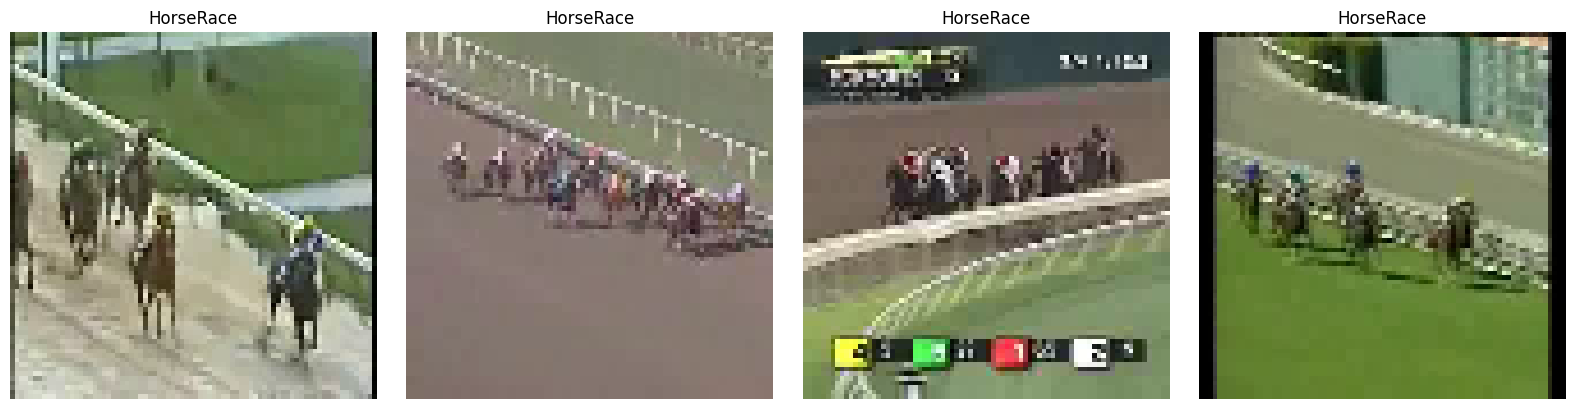

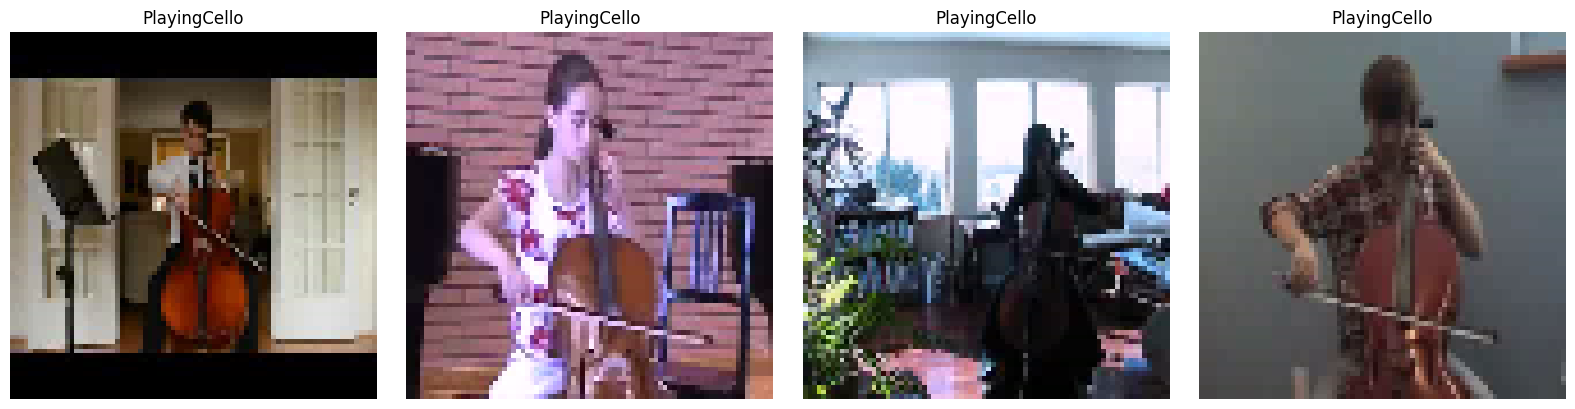

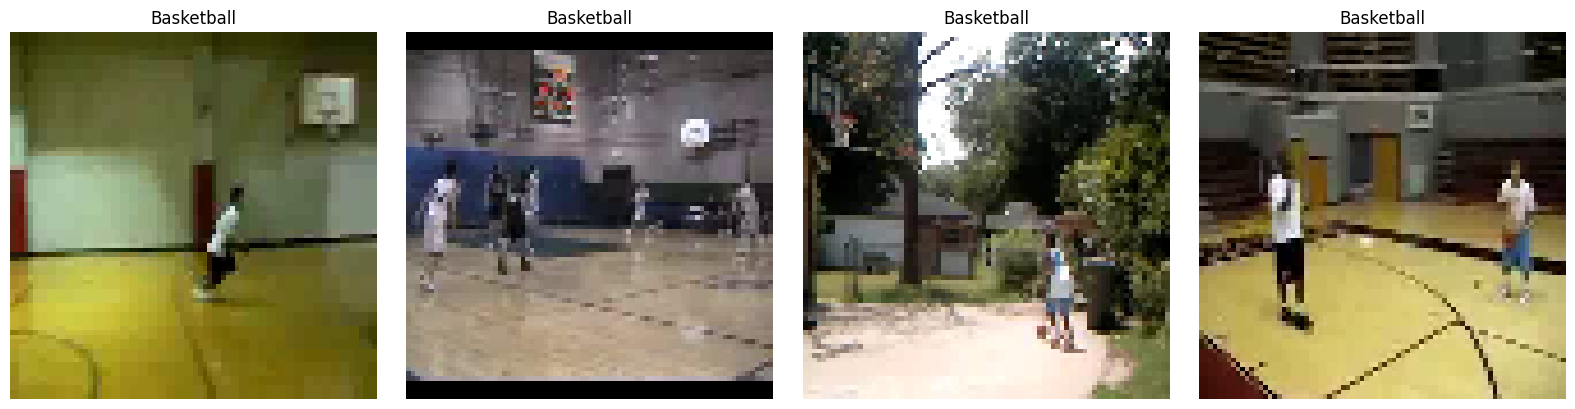

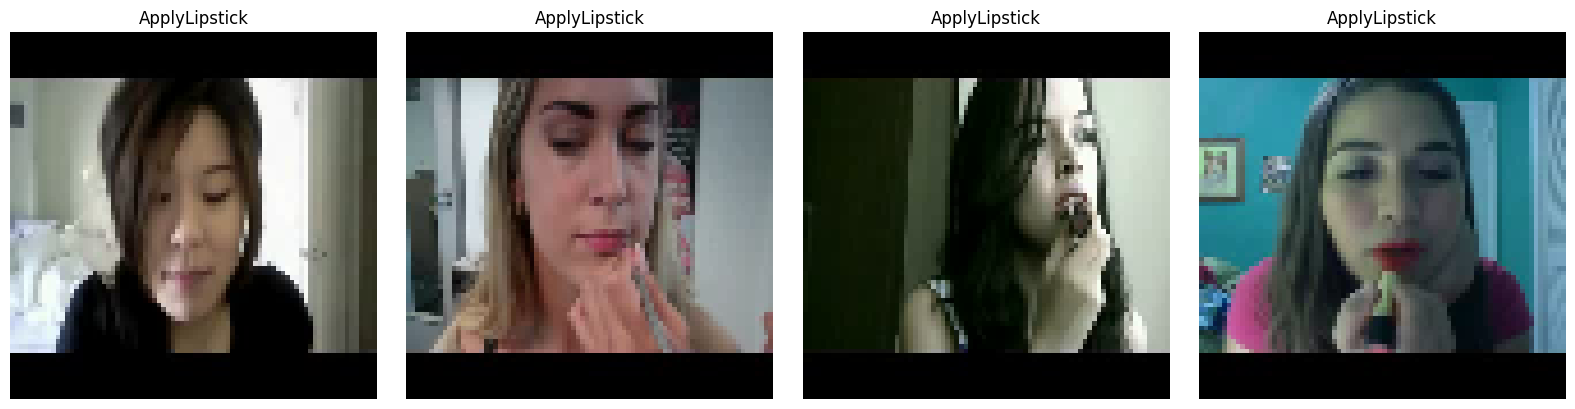

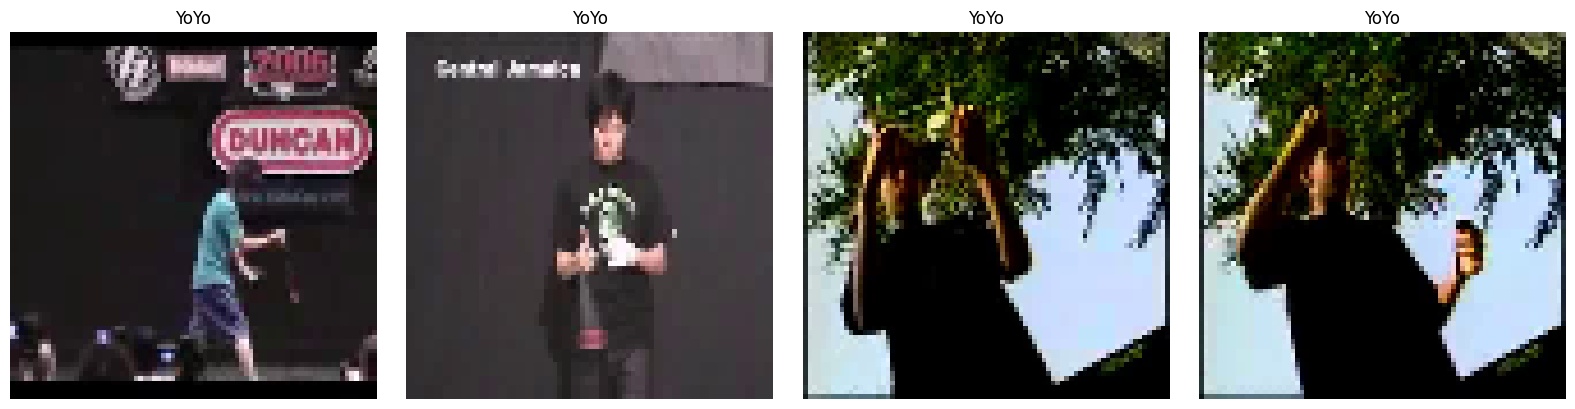

In [30]:
video_directory = './UCF101/UCF-101' 
categories = ['HorseRace', 'PlayingCello', 'Basketball', 'ApplyLipstick', 'YoYo']
num_videos_per_category = 4 

num_images_per_row = 4
image_width = 80 
image_height = 80 

for category in categories:
    category_directory = os.path.join(video_directory, category)
    videos = os.listdir(category_directory)
    videos = random.sample(videos, num_videos_per_category)

    fig, axs = plt.subplots(1, num_images_per_row, figsize=(16, 4))

    for i, video in enumerate(videos):
        video_path = os.path.join(category_directory, video)
        cap = cv2.VideoCapture(video_path)

        ret, frame = cap.read() 
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) 

        cap.release()

        frame = cv2.resize(frame, (image_width, image_height))

        axs[i].imshow(frame)
        axs[i].set_title(category)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


In [48]:
video_path

'./UCF101/UCF-101\\YoYo\\v_YoYo_g06_c03.avi'

## Step 2 : data preprocessing

In [70]:
height , width = 64, 64
SEQUENCE_LENGTH = 20
DATASET_DIR = './UCF101/UCF-101/'
labels_names = ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam']

In [27]:
def extraction_images(video_path):
 
    frames_list = []
    
    video_reader = cv2.VideoCapture(video_path)
 
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)
 
    for frame_counter in range(SEQUENCE_LENGTH):
 
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        success, frame = video_reader.read()
 
        if not success:
            break
 
        resized_frame = cv2.resize(frame, (width, height))
        
        normalized_frame = resized_frame / 255
        
        frames_list.append(normalized_frame)
    
    video_reader.release()
 
    return frames_list

### Function create_dataset

In [20]:
def create_dataset():

    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam']):

        print(f'Extracting: {class_name}')

        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:

            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            images = extraction_images(video_file_path)

            if len(images) == SEQUENCE_LENGTH:

                features.append(images)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    labels = np.array(labels)

    return features, labels, video_files_paths

In [21]:
features, labels, video_files_paths = create_dataset()

Extracting: ApplyEyeMakeup
Extracting: ApplyLipstick
Extracting: Archery
Extracting: BabyCrawling
Extracting: BalanceBeam


In [22]:
one_hot_encoded_labels = to_categorical(labels)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True)

In [24]:
model = Sequential()

model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                     recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                  height, width, 3)))

model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                     recurrent_dropout=0.2, return_sequences=True))

model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                     recurrent_dropout=0.2, return_sequences=True))

model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                     recurrent_dropout=0.2, return_sequences=True))

model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
#model.add(TimeDistributed(Dropout(0.2)))

model.add(Flatten())

model.add(Dense(len(categories), activation = "softmax"))

########################################################################################################################

# Display the models summary.
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3  (None, 20, 31, 31, 4)     0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 20, 31, 31, 4)     0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 20, 15, 15, 8)     0         
 g3D)                                                            
                                                        

In [27]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
histo_fit = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 15, verbose=1)

Epoch 1/15
16/16 [==============================] - 169s 9s/step - loss: 1.4492 - accuracy: 0.3747 - val_loss: 1.3083 - val_accuracy: 0.4472
Epoch 2/15
16/16 [==============================] - 151s 9s/step - loss: 1.2450 - accuracy: 0.4845 - val_loss: 1.2292 - val_accuracy: 0.5217
Epoch 3/15
16/16 [==============================] - 140s 9s/step - loss: 1.0618 - accuracy: 0.5631 - val_loss: 1.7049 - val_accuracy: 0.4286
Epoch 4/15
16/16 [==============================] - 135s 8s/step - loss: 0.9817 - accuracy: 0.6190 - val_loss: 0.9578 - val_accuracy: 0.6646
Epoch 5/15
16/16 [==============================] - 134s 8s/step - loss: 0.7572 - accuracy: 0.7164 - val_loss: 0.9801 - val_accuracy: 0.6522
Epoch 6/15
16/16 [==============================] - 147s 9s/step - loss: 0.6883 - accuracy: 0.7412 - val_loss: 0.6959 - val_accuracy: 0.7329
Epoch 7/15
16/16 [==============================] - 118s 7s/step - loss: 0.6055 - accuracy: 0.7785 - val_loss: 0.6737 - val_accuracy: 0.7516
Epoch 8/15
16

In [28]:
vgg16 = VGG16(weights = 'imagenet' ,include_top=False, input_shape=(64, 64, 3))

58889256/58889256 [==============================] - 13s 0us/step


In [80]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

In [81]:
plot_scores(histo_fit)

NameError: name 'histo_fit' is not defined

In [1]:
model.save('model.keras')

NameError: name 'model' is not defined

In [2]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('model.keras')

# Show the model architecture
new_model.summary()

NameError: name 'tf' is not defined

In [10]:
def read_video():
    
    features = []
    label = []
    video_path = '\UCF101\UCF-101\Archery\v_Archery_g23_c06.avi'

    print(f'Extracting video: {class_name}')

    images = extraction_images(video_file_path)

    if len(images) == SEQUENCE_LENGTH:

        features.append(images)
        label.append(class_index)

    features = np.asarray(features)
    label = np.array(labels)

    return features, labels, video_path

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 0-6: truncated \UXXXXXXXX escape (3526561555.py, line 5)

In [63]:
prediction_video = extraction_images("./UCF101/UCF-101\\YoYo\\v_YoYo_g06_c03.avi");

video_feature = [] 
video_feature.append(prediction_video)
video_feature = np.asarray(video_feature)

In [64]:
video_feature

array([[[[[0.00392157, 0.00784314, 0.        ],
          [0.        , 0.04705882, 0.01176471],
          [0.24705882, 0.37254902, 0.29803922],
          ...,
          [0.16078431, 0.2627451 , 0.25490196],
          [0.01568627, 0.1372549 , 0.1254902 ],
          [0.30588235, 0.36862745, 0.36470588]],

         [[0.        , 0.        , 0.        ],
          [0.25098039, 0.34117647, 0.29019608],
          [0.04313725, 0.18823529, 0.11764706],
          ...,
          [0.18431373, 0.29019608, 0.28235294],
          [0.35686275, 0.47843137, 0.46666667],
          [0.        , 0.07058824, 0.06666667]],

         [[0.        , 0.00392157, 0.        ],
          [0.31764706, 0.41568627, 0.36470588],
          [0.57254902, 0.70196078, 0.63137255],
          ...,
          [0.08235294, 0.19215686, 0.18431373],
          [0.17647059, 0.30588235, 0.29411765],
          [0.01176471, 0.09411765, 0.09019608]],

         ...,

         [[0.36862745, 0.36470588, 0.28627451],
          [0.86666667,

In [67]:
new_model.predict(video_feature)

1/1 [==============================] - 1s 1s/step


array([[0.00066692, 0.02471655, 0.31526276, 0.04049891, 0.6188549 ]],
      dtype=float32)

In [71]:
labels_names

['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam']

In [77]:
def plot_scores(train) :
    # summarize history for accuracy
    plt.plot(train.history['accuracy'])
    plt.plot(train.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(train.history['loss'])
    plt.plot(train.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [78]:
plot_scores(histo_fit)

NameError: name 'histo_fit' is not defined